In [1]:
import csv
import gzip
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
import swifter
from tqdm.notebook import tqdm

from sentence_transformers import SentenceTransformer, util

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
import seaborn as sns
style.use('seaborn-poster')

DATA_DIR = Path('/mnt/raid/zp/fluxion_test_task/data/csse_covid_19_daily_reports')

In [2]:
#!pip install -U sentence-transformers

# Build dataset

In [3]:
data_path = DATA_DIR / 'data.csv.gz'
data = pd.DataFrame()

if not data_path.exists():
    for p in tqdm(DATA_DIR.iterdir()):
        if not p.name.endswith('.csv'):
            continue

        df = pd.read_csv(p)
        date = datetime.strptime(p.name[:-4], '%m-%d-%Y').date()
        df['Date'] = date
        data = data.append(df, ignore_index=True)

    data.to_csv(data_path, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)
else:
    data = pd.read_csv(data_path)


/home/jupyter/.pyenv/versions/3.7.7/envs/nemo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
data.columns

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incident_Rate', 'Case_Fatality_Ratio', 'Date',
       'Incidence_Rate', 'Case-Fatality_Ratio', 'Province/State',
       'Country/Region', 'Last Update', 'Latitude', 'Longitude'],
      dtype='object')

# Fix Latitude and Longitude

Latitude

In [5]:
lat_cond = data['Lat'].isnull()
latitude_cond = data['Latitude'].isnull()

In [6]:
lat_cond.sum() + latitude_cond.sum(), data.shape

(4057515, (3966193, 22))

Not equel, check that both columns don't have values

In [7]:
data[~lat_cond & ~latitude_cond][['Lat', 'Latitude']]

,Lat,Latitude


In [8]:
data.loc[lat_cond, 'Lat'] = data[lat_cond]['Latitude']

In [9]:
pr_nan_cnt = lat_cond.sum()
now_nan_cnt = data['Lat'].isnull().sum()

f'Was nan values {pr_nan_cnt}, now {now_nan_cnt}'

'Was nan values 96814, now 91322'

Longitude

In [10]:
long_cond = data['Long_'].isnull()
longitude_cond = data['Longitude'].isnull()

long_cond.sum() + longitude_cond.sum(), data.shape

(4057515, (3966193, 22))

In [11]:
data[~long_cond & ~longitude_cond][['Long_', 'Longitude']]

,Long_,Longitude


In [12]:
data.loc[long_cond, 'Long_'] = data[long_cond]['Longitude']

In [13]:
pr_nan_cnt = long_cond.sum()
now_nan_cnt = data['Long_'].isnull().sum()

f'Was nan values {pr_nan_cnt}, now {now_nan_cnt}'

'Was nan values 96814, now 91322'

In [14]:
data = data.drop(['Latitude', 'Longitude'], axis=1)

# Case-Fatality_Ratio -> Case_Fatality_Ratio

In [15]:
cfr_cond = data['Case_Fatality_Ratio'].isnull()
data.loc[cfr_cond, 'Case_Fatality_Ratio'] = data[cfr_cond]['Case-Fatality_Ratio']
data = data.drop(['Case-Fatality_Ratio'], axis=1)

# Incidence_Rate -> Incident_Rate

In [16]:
true_col = 'Incident_Rate'
del_col = 'Incidence_Rate'

cond = data[true_col].isnull()
data.loc[cond, true_col] = data[cond][del_col]
data = data.drop([del_col], axis=1)

# Last_Update -> Last Update

In [17]:
true_col = 'Last Update'
del_col = 'Last_Update'

cond = data[true_col].isnull()
data.loc[cond, true_col] = data[cond][del_col]
data = data.drop([del_col], axis=1)

# Country/Region -> Country_Region

In [18]:
true_col = 'Country_Region'
del_col = 'Country/Region'

cond = data[true_col].isnull()
data.loc[cond, true_col] = data[cond][del_col]
data = data.drop([del_col], axis=1)

# Province/State -> Province_State

In [19]:
true_col = 'Province_State'
del_col = 'Province/State'

cond = data[true_col].isnull()
data.loc[cond, true_col] = data[cond][del_col]
data = data.drop([del_col], axis=1)

# Delete Combined_Key

In [20]:
combined_key_set = set(data['Combined_Key'].dropna().unique())
country_region_set = set(data['Country_Region'].dropna().unique())
province_state_set = set(data['Province_State'].dropna().unique())

In [21]:
first_last_chars = set()
for arr in [combined_key_set, country_region_set, province_state_set]:
    for el in arr:
        first_last_chars.add(el[0])
        first_last_chars.add(el[-1])

In [22]:
first_last_chars

{' ',
 ')',
 '*',
 ',',
 '.',
 '0',
 '2',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'y',
 'z'}

In [23]:
def text_norm(s):
    s = s.lower()
    s = s.strip(' )*,.')
    
    return s

combined_key_set = set([text_norm(s) for s in combined_key_set])
country_region_set = set([text_norm(s) for s in country_region_set])
province_state_set = set([text_norm(s) for s in province_state_set])

intersection with Combined_Key

In [24]:
len(combined_key_set.intersection(country_region_set)) / len(combined_key_set)

0.04716073147256978

intersection with Province_State

In [25]:
len(combined_key_set.intersection(province_state_set)) / len(combined_key_set)

0.0019249278152069298

In [26]:
column_nan_cor = pd.DataFrame()
column_nan_cor['Combined_Key'] = ~data['Combined_Key'].isnull()
column_nan_cor['Country_Region'] = data['Country_Region'].isnull()
column_nan_cor['Province_State'] = data['Province_State'].isnull()

In [27]:
column_nan_cor.corr()

,Combined_Key,Country_Region,Province_State
Combined_Key,1.00000,NaN,-0.07873
Country_Region,NaN,NaN,NaN
Province_State,-0.07873,NaN,1.00000


Not sure about Combined_Key

# Check that the coordinates correspond to the same region

In [28]:
columns = ['Lat', 'Long_', 'Province_State', 'Country_Region']
data_short = data[columns].drop_duplicates()

In [29]:
groups = data_short.groupby(['Lat', 'Long_'])
groups_cnt = groups.count().sort_values(['Province_State', 'Country_Region'], ascending=False).head(20)
groups_cnt

,,Province_State,Country_Region
Lat,Long_,,
0.000000,0.000000,47,49
35.443700,139.638000,5,5
18.335800,-64.896300,3,3
22.166700,113.550000,3,3
22.300000,114.200000,3,3
37.648900,-122.665500,3,3
23.700000,121.000000,2,3
-51.796300,-59.523600,2,2
4.000000,-53.000000,2,2


In [30]:
for row in groups_cnt.itertuples():
    print('##########')
    print(groups.get_group(row.Index).to_markdown())


##########
|         |   Lat |   Long_ | Province_State   | Country_Region   |
|--------:|------:|--------:|:-----------------|:-----------------|
|  200606 |     0 |       0 | Michigan         | US               |
|  200607 |     0 |       0 | Tennessee        | US               |
|  200608 |     0 |       0 | Utah             | US               |
|  201284 |     0 |       0 | Alaska           | US               |
|  201285 |     0 |       0 | Arizona          | US               |
|  201286 |     0 |       0 | Arkansas         | US               |
|  201287 |     0 |       0 | Colorado         | US               |
|  201288 |     0 |       0 | Florida          | US               |
|  201289 |     0 |       0 | Georgia          | US               |
|  201290 |     0 |       0 | Hawaii           | US               |
|  201291 |     0 |       0 | Illinois         | US               |
|  201292 |     0 |       0 | Kentucky         | US               |
|  201293 |     0 |       0 | Louisia

# After this, it is interesting to look at other regions (similar regions)

In [31]:
province_state_ls = data['Province_State'].dropna().unique()
country_region_ls = data['Country_Region'].dropna().unique()

model = SentenceTransformer('all-MiniLM-L6-v2')
province_state_emb = model.encode(province_state_ls)
country_region_emb = model.encode(country_region_ls)

province_state_scores = util.cos_sim(province_state_emb, province_state_emb)
province_state_scores = np.asarray(province_state_scores)
country_region_scores = util.cos_sim(country_region_emb, country_region_emb)
country_region_scores = np.asarray(country_region_scores)

Province_State

In [32]:
th = 0.9
for i, name in enumerate(province_state_ls):
    vec = province_state_scores[i].copy()
    idxes = vec.argsort()[::-1]
    if vec[idxes[1]] < th:
        continue
        
    print(name)
    for j in idxes[1:]:
        if vec[j] < th:
            break
        print(f'\t {province_state_ls[j]} {vec[j]}')
    print()


East Flanders
	 West Flanders 0.9180420637130737

West Flanders
	 East Flanders 0.9180420637130737

Baja California
	 Baja California Sur 0.904107928276062

Baja California Sur
	 Baja California 0.904107928276062

Kirov Oblast
	 Kirovohrad Oblast 0.9530563354492188

Moscow Oblast
	 Vladimir Oblast 0.9248462915420532

Nizhny Novgorod Oblast
	 Novgorod Oblast 0.9241964817047119

Novgorod Oblast
	 Nizhny Novgorod Oblast 0.9241964817047119

Vladimir Oblast
	 Moscow Oblast 0.9248462915420532

New York
	 New York City, NY 0.916917085647583

Virgin Islands
	 Virgin Islands, U.S. 0.9377797842025757
	 United States Virgin Islands 0.9190550446510315
	 British Virgin Islands 0.9124003648757935

Cherkasy Oblast
	 Chernihiv Oblast 0.9142993688583374
	 Chernivtsi Oblast 0.9038024544715881

Chernihiv Oblast
	 Chernivtsi Oblast 0.9553263187408447
	 Cherkasy Oblast 0.9142993688583374

Chernivtsi Oblast
	 Chernihiv Oblast 0.9553263187408447
	 Cherkasy Oblast 0.9038024544715881

Kirovohrad Oblast
	 Kirov

In [33]:
th = 0.9
for i, name in enumerate(country_region_ls):
    vec = country_region_scores[i].copy()
    idxes = vec.argsort()[::-1]
    if vec[idxes[1]] < th:
        continue
        
    print(name)
    for j in idxes[1:]:
        if vec[j] < th:
            break
        print(f'\t {country_region_ls[j]} {vec[j]}')
    print()

Azerbaijan
	 Azerbaijan 1.0000001192092896

Bahamas
	 The Bahamas 0.9642459750175476
	 Bahamas, The 0.9477136135101318

Gambia
	 The Gambia 0.9676536321640015
	 Gambia, The 0.9506157636642456

Korea, South
	 South Korea 0.9481249451637268

Moldova
	 Republic of Moldova 0.9362770318984985

Taiwan*
	 Taiwan 0.9030666351318359

Taiwan
	 Taiwan* 0.9030666351318359

South Korea
	 Korea, South 0.9481249451637268

Bahamas, The
	 The Bahamas 0.9650625586509705
	 Bahamas 0.9477136135101318

Gambia, The
	 The Gambia 0.9634202718734741
	 Gambia 0.9506157636642456

The Bahamas
	 Bahamas, The 0.9650625586509705
	 Bahamas 0.9642459750175476

The Gambia
	 Gambia 0.9676536321640015
	 Gambia, The 0.9634202718734741

Republic of Moldova
	 Moldova 0.9362770318984985

Saint Martin
	 St. Martin 0.9050337672233582

 Azerbaijan
	 Azerbaijan 1.0000001192092896

St. Martin
	 Saint Martin 0.9050337672233582



# Some Graphs 

### Number per time for each case

<AxesSubplot:xlabel='Date'>

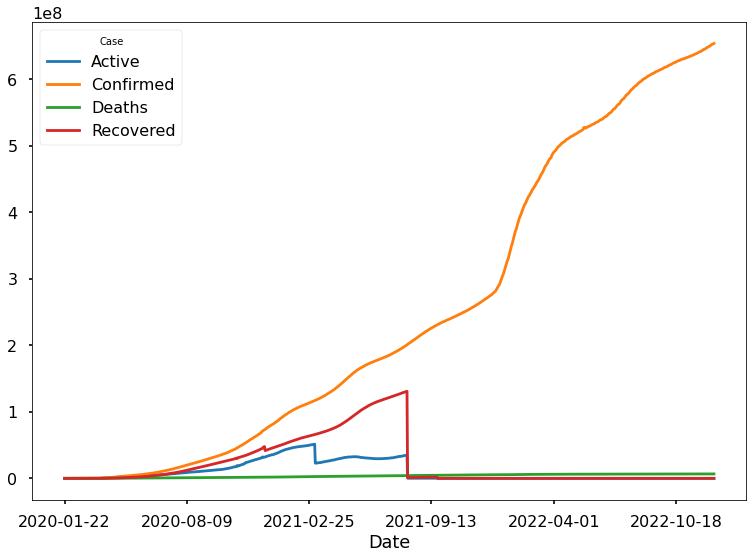

In [34]:
temp = data.groupby('Date')['Recovered', 'Deaths', 'Active', 'Confirmed'].sum().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active', 'Confirmed'],
                 var_name='Case', value_name='Count')

temp.pivot(index='Date', columns='Case', values='Count').plot()

Something strange

### Country distribution

In [35]:
temp = data.groupby('Country_Region')['Recovered', 'Deaths', 'Active', 'Confirmed'].sum().reset_index()
temp = temp.melt(id_vars="Country_Region", value_vars=['Recovered', 'Deaths', 'Active', 'Confirmed'],
                 var_name='Case', value_name='Count')
temp = temp.pivot(index='Country_Region', columns='Case', values='Count').reset_index()


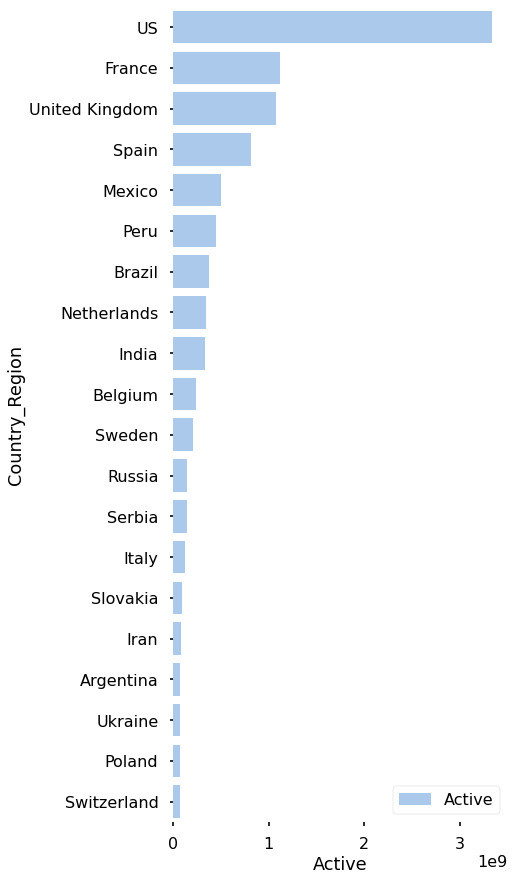

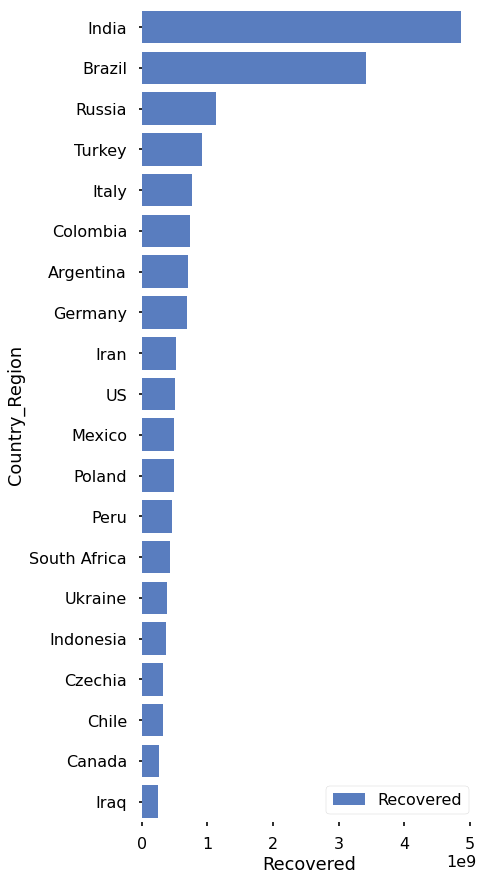

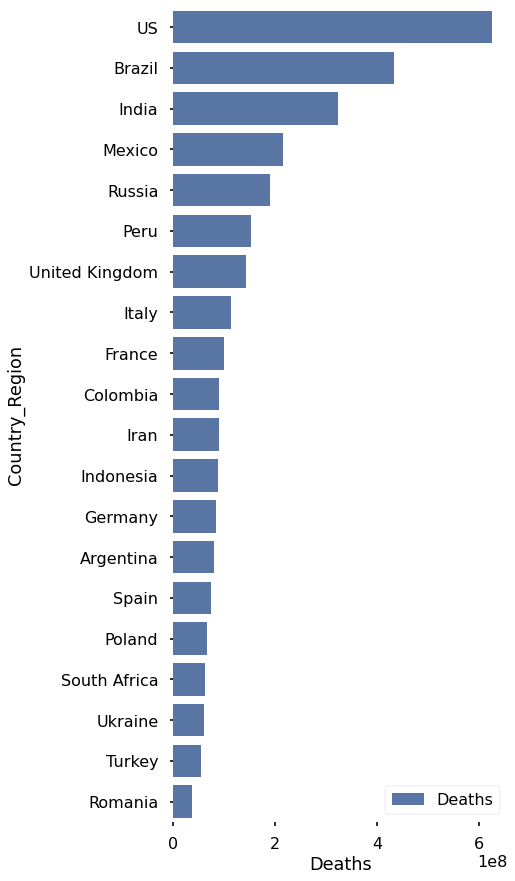

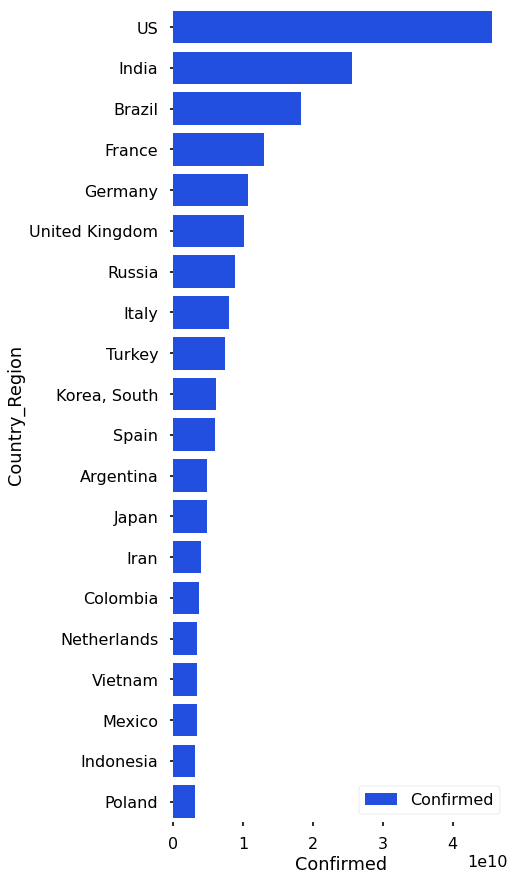

In [36]:
color_map = {'Active': "pastel", 'Recovered': 'muted', "Deaths": "deep", 'Confirmed': 'bright'}
for case in ["Active", "Recovered", "Deaths", 'Confirmed']:
    f, ax = plt.subplots(figsize=(6, 15))
    
    temp_ = temp.sort_values(case, ascending=False).reset_index(drop=True)[:20]
    
    sns.set_color_codes(color_map[case])
    sns.barplot(x=case, y="Country_Region", data=temp_,
                label=case, color="b")

    ax.legend(ncol=2, loc="lower right", frameon=True)
    sns.despine(left=True, bottom=True)

Strange behavior of some countries.

### Plot per country

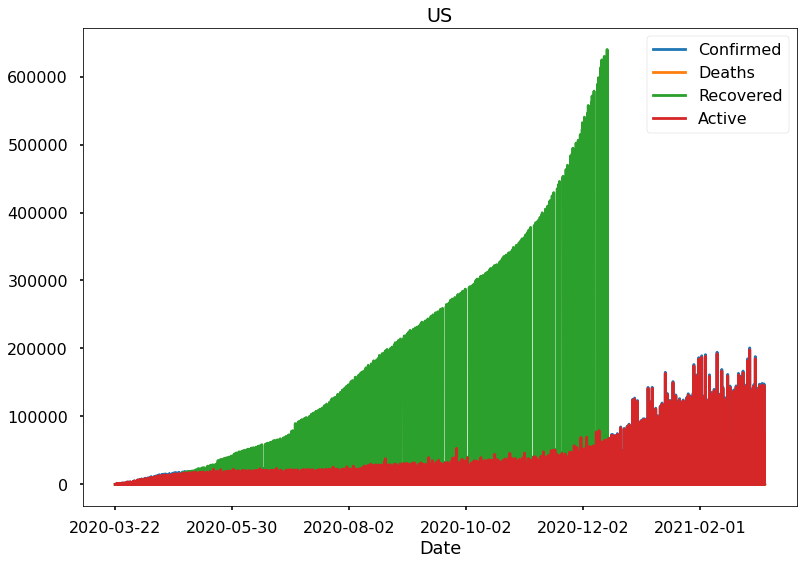

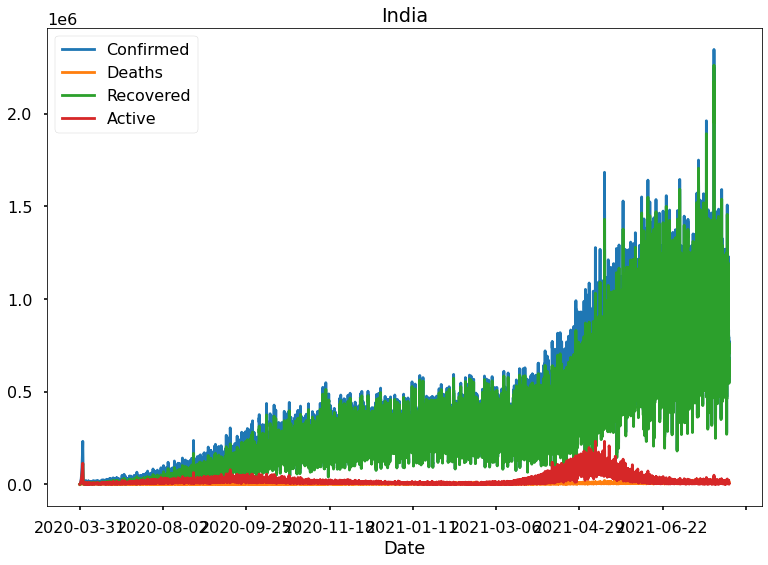

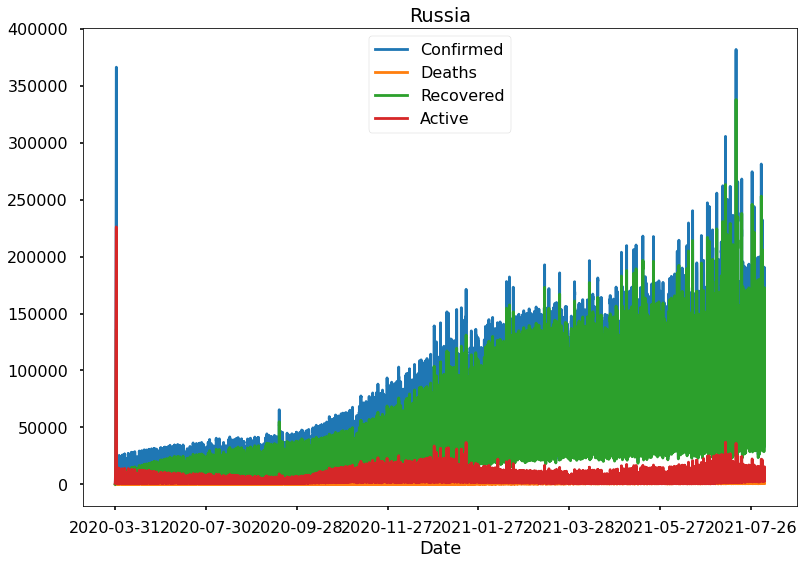

In [37]:
countries = ['US', 'India', 'Russia']
plot_columns = ['Date', 'Confirmed', 'Deaths', 'Recovered', 'Active']

for c in countries:
    cond = data['Country_Region'] == c
    temp = data[cond][plot_columns].dropna().copy()
    temp = temp.sort_values('Date').reset_index(drop=True)
    temp[plot_columns[1:]] = temp[plot_columns[1:]].rolling(window=10).mean()
    temp = temp.dropna()
    temp[plot_columns].plot(x='Date', title=c)


I use moving average with windows=10, but the spread from day to day is still large